This notebook shows how to use `freud`'s `EnvironmentCluster` class for searching for unique local environments in a complex crystal, $\gamma$-Brass.

See https://www.nature.com/articles/s41467-018-07977-2 for more sophisticated examples of using this environment detection scheme and the definition of a local environment (in the Supplementary Information)

Prior knowledge of the structure of interest is necessary for selecting parameters and interpreting the results. For example, the $\gamma$-Brass conventional unit cell has 52 particles (26 in primitive cell) and 4 unique Wyckoff sites. The particles in one unit cell may have different number of nearest neighbors (coordination number).

In [1]:
from time import time

import freud
import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Generate a perfect gamma-Brass crystal using its conventional unit cell
a = 2
unit_cell = [a, a, a, 0, 0, 0]
basis_positions = [
    [-0.67226005, -0.67226005, -0.67226005],
    [-0.67226005, -0.32773998, -0.32773998],
    [-0.32773998, -0.32773998, -0.67226005],
    [-0.32773998, -0.67226005, -0.32773998],
    [-0.17225999, -0.17225999, -0.17225999],
    [-0.17225999, -0.82774, -0.82774],
    [-0.82774, -0.82774, -0.17225999],
    [-0.82774, -0.17225999, -0.82774],
    [-0.89219, -0.89219, -0.89219],
    [-0.89219, -0.10780999, -0.10780999],
    [-0.10780999, -0.10780999, -0.89219],
    [-0.10780999, -0.89219, -0.10780999],
    [-0.39218998, -0.39218998, -0.39218998],
    [-0.39218998, -0.60781, -0.60781],
    [-0.60781, -0.60781, -0.39218998],
    [-0.60781, -0.39218998, -0.60781],
    [-0.64421, -1.0, -1.0],
    [-1.0, -0.35579, -1.0],
    [-0.35579, -1.0, -1.0],
    [-1.0, -0.64421, -1.0],
    [-1.0, -1.0, -0.35579],
    [-1.0, -1.0, -0.64421],
    [-0.14420998, -0.5, -0.5],
    [-0.5, -0.85579, -0.5],
    [-0.85579, -0.5, -0.5],
    [-0.5, -0.14420998, -0.5],
    [-0.5, -0.5, -0.85579],
    [-0.5, -0.5, -0.14420998],
    [-0.68844, -0.68844, -0.96326005],
    [-0.68844, -0.31155998, -0.03673998],
    [-0.31155998, -0.31155998, -0.96326005],
    [-0.31155998, -0.68844, -0.03673998],
    [-0.96326005, -0.68844, -0.68844],
    [-0.03673998, -0.68844, -0.31155998],
    [-0.96326005, -0.31155998, -0.31155998],
    [-0.03673998, -0.31155998, -0.68844],
    [-0.68844, -0.03673998, -0.31155998],
    [-0.68844, -0.96326005, -0.68844],
    [-0.31155998, -0.03673998, -0.68844],
    [-0.31155998, -0.96326005, -0.31155998],
    [-0.18844, -0.18844, -0.46326],
    [-0.18844, -0.81156003, -0.53674],
    [-0.81156003, -0.81156003, -0.46326],
    [-0.81156003, -0.18844, -0.53674],
    [-0.46326, -0.18844, -0.18844],
    [-0.53674, -0.18844, -0.81156003],
    [-0.46326, -0.81156003, -0.81156003],
    [-0.53674, -0.81156003, -0.18844],
    [-0.18844, -0.53674, -0.81156003],
    [-0.18844, -0.46326, -0.18844],
    [-0.81156003, -0.53674, -0.18844],
    [-0.81156003, -0.46326, -0.81156003],
]
uc = freud.data.UnitCell(box=unit_cell, basis_positions=basis_positions)
n = 2
noise = 0.0
gb_lattice = uc.generate_system(n, sigma_noise=noise)

The gb lattice has 416 particles


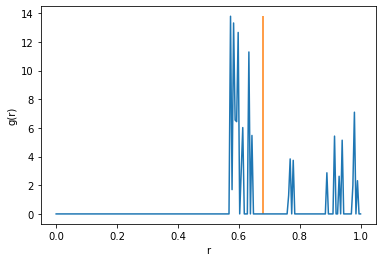

In [3]:
# Plot the rdf for determining the parameters

r_min = 0
r_max = a / 2
nbins = 200

box, points = gb_lattice
print(f"The gb lattice has {len(points)} particles")
rdf = freud.density.RDF(bins=nbins, r_max=r_max, r_min=r_min)
rdf.compute((box, points))

fig, ax = plt.subplots()
ax.plot(np.linspace(r_min, r_max, nbins), rdf.rdf)
ax.set_xlabel("r")
ax.set_ylabel("g(r)")
plt.vlines(0.68, 0, max(rdf.rdf), colors="C1")
plt.show()

Notice that the first well appears at around r = 0.68. We use this as the cut off radius for `env_neighbor`. We do not use `num_neighbors` here for `env_neighbor` because as mentioned above, the particles in the $\gamma$-Brass structure may have different coordination numbers, unlike particles in simpler crystals such as BCC (coordination number = 8).

For the `neighbor` parameter, which specifies the number of neighbors the environment cluster of each particle will be compared against with, we choose arbitrarily `{'num_neighbors': 20}` because we set `global_search=True`. When `global_search=True`, the neighbor list provided to `neighbor` is ignored and environments of every single pair of particles in the system are compared. Since this system contains only 416 particles, the search does not slow down the computation significantly.

Total time spent: 0.09846115112304688 s


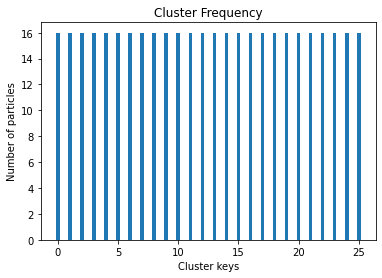

In [4]:
t0 = time()
first_well = 0.68
env_cluster = freud.environment.EnvironmentCluster()

threshold = 0.2 * first_well
neighbor = {"num_neighbors": 20}
env_neighbor = {"r_max": first_well}

env_cluster.compute(
    (box, points),
    threshold=threshold,
    neighbors=neighbor,
    env_neighbors=env_neighbor,
    registration=False,
    global_search=True,
)

t1 = time()
print(f"Total time spent: {t1 - t0} s")

fig, ax = plt.subplots()
ax.hist(
    env_cluster.cluster_idx,
    bins=range(env_cluster.num_clusters + 1),
    align="left",
    rwidth=0.3,
)
ax.set_xlabel("Cluster keys")
ax.set_ylabel("Number of particles")
plt.title("Cluster Frequency")
plt.show()

From the figure above, we can see that 26 different clusters were found, with each containing 16 particles. Next we try with `registration=True`, which means that clusters differ only by orientation will be classified as one type of cluster. 

Total time spent: 296.32149624824524 s


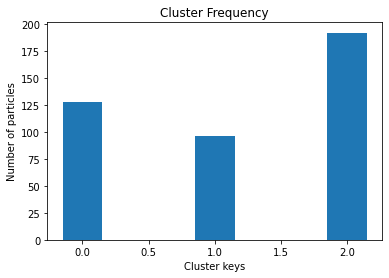

In [5]:
t0 = time()
first_well = 0.68
env_cluster = freud.environment.EnvironmentCluster()

threshold = 0.2 * first_well
neighbor = {"num_neighbors": 20}
env_neighbor = {"r_max": first_well}

env_cluster.compute(
    (box, points),
    threshold=threshold,
    neighbors=neighbor,
    env_neighbors=env_neighbor,
    registration=True,
    global_search=True,
)

t1 = time()
print(f"Total time spent: {t1 - t0} s")

fig, ax = plt.subplots()
ax.hist(
    env_cluster.cluster_idx,
    bins=range(env_cluster.num_clusters + 1),
    align="left",
    rwidth=0.3,
)
ax.set_xlabel("Cluster keys")
ax.set_ylabel("Number of particles")
plt.title("Cluster Frequency")
plt.show()

Next we plot the number of particles that make up a cluster.

In [7]:
num_particles_list = []
for i in range(env_cluster.num_clusters):
    num_particles = 0
    for vector in env_cluster.cluster_environments[i]:
        if np.power(vector, 2).sum() > 0:
            num_particles += 1
    num_particles_list.append(num_particles)

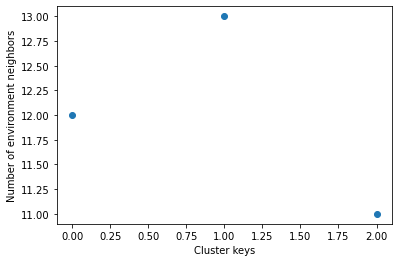

In [8]:
fig, ax = plt.subplots()
ax.scatter(range(0, env_cluster.num_clusters, 1), num_particles_list)
ax.set_xlabel("Cluster keys")
ax.set_ylabel("Number of environment neighbors")
plt.show()

From the figure above, we can see that indeed the particles have different coordination numbers.

In [6]:
# Run this and visualize with fresnel, or just insert figures
import gsd.hoomd

name = "gb"
typeid = env_cluster.cluster_idx.copy()
snapshot = gsd.hoomd.Snapshot()
snapshot.particles.N = np.shape(points)[0]
snapshot.particles.position = points
snapshot.particles.types = [str(i) for i in np.unique(typeid)]
snapshot.particles.typeid = typeid
snapshot.particles.diameter = [1.0] * np.shape(points)[0]
snapshot.configuration.box = [box.Lx, box.Ly, box.Lz, box.xy, box.xz, box.yz]
with gsd.hoomd.open(f"{name}_lattice.gsd", mode="wb") as f:
    f.append(snapshot)